# ***MAIN FUNCTIONALITY***

In [1]:
import pandas as pd
import plotly.express as px
import seaborn as sns

from meteo.Site import Site
from solar.SolarPVPanel import SolarPVPanel
from solar.SolarPVArray import SolarPVArray
from solar.SolarPVModel import SolarPVModel

from misc.log_config import configure_logging
from misc.util import load_pv_model

configure_logging()
pd.options.display.float_format = '{:.3f}'.format

# Set up site location and get TMY data
name = ""
address = "York St, Belfast, BT15 1ED"
client = "Ulster University"

site = Site(name=name, 
            address=address, 
            client=client, 
            latitude=54.60452, 
            longitude=-5.92860, 
            size=100)

# Set up PV panel being used
panel_kwp = 0.3538
size_m2 = 1.990
eff = 0.2237
cell_temp_coeff = -0.004
cell_NOCT = 48
lifespan = 25
pv_eol_derating = 0.88
refraction_index = 0.05

pv_panel = SolarPVPanel(panel_kwp, size_m2, eff, cell_temp_coeff, 
                        cell_NOCT, lifespan, pv_eol_derating, refraction_index)


# Set up PV arrays
num_pv_panels = 4
surface_pitch = 35
surface_azimuth = -90
albedo = 0.2
cost_per_kWp = 1250

pv_array_1 = SolarPVArray(pv_panel, num_pv_panels, surface_pitch, surface_azimuth, albedo, cost_per_kWp)
pv_array_2 = SolarPVArray(pv_panel, num_pv_panels, surface_pitch, -45)
pv_array_3 = SolarPVArray(pv_panel, num_pv_panels, surface_pitch, 0)
pv_array_4 = SolarPVArray(pv_panel, num_pv_panels, surface_pitch, 45)
pv_array_5 = SolarPVArray(pv_panel, num_pv_panels, surface_pitch, 90)

pv_arrays = [pv_array_1, pv_array_2, pv_array_3, pv_array_4, pv_array_5]


# Run the model
pv_model = SolarPVModel(site, pv_arrays)

# Save model as .wmm file
pv_model.save_model()

# Load .wwm model from file
pv_model = load_pv_model()

print("")
print(f"{sum(array.pv_kwp for array in pv_model.arrays)}kWp Solar PV modelled covering a {sum(array.area_m2 for array in pv_model.arrays)}m2 area.")


2024-02-23 19:43:44,753 - INFO - Fetching TMY data for latitude: 54.60452, longitude: -5.9286
2024-02-23 19:43:45,704 - INFO - HTTP Request: GET https://re.jrc.ec.europa.eu/api/tmy?lat=54.60452&lon=-5.9286&startyear=2005&endyear=2015&outputformat=json "HTTP/1.1 200 OK"
2024-02-23 19:43:46,057 - INFO - TMY data obtained for: 54.60452, longitude: -5.9286
2024-02-23 19:43:46,058 - INFO - *******************
2024-02-23 19:43:46,059 - INFO - Solar PV Panel created: Size: 0.3538kW, Size: 1.99m2, Efficiency: 22.37%, Lifespan: 25yrs
2024-02-23 19:43:46,060 - INFO - Solar PV array created: Size: 1.415kW, Size: 7.96m2, Azimuth: -90deg, Lifespan: 25yrs, Pitch: 35deg, Efficiency: 22.37%
2024-02-23 19:43:46,060 - INFO - Solar PV array created: Size: 1.415kW, Size: 7.96m2, Azimuth: -45deg, Lifespan: 25yrs, Pitch: 35deg, Efficiency: 22.37%
2024-02-23 19:43:46,061 - INFO - Solar PV array created: Size: 1.415kW, Size: 7.96m2, Azimuth: 0deg, Lifespan: 25yrs, Pitch: 35deg, Efficiency: 22.37%
2024-02-23 1


7.075kWp Solar PV modelled covering a 39.8m2 area.


In [5]:
pv_model.array_model(0).E_POA_kWm2.sum()

869.1227452409016

In [2]:
pv_model.summary

2024-02-23 16:48:10,698 - INFO - Generating Solar PV model statistical analysis.
2024-02-23 16:48:10,700 - INFO - Solar PV model statistical analysis completed.


PV_Gen_kWh_Annual              6322.910
PV_Gen_kWh_Lifetime          148209.017
E_POA_kWm2_Annual               956.222
Panel_POA_kWm2_Annual           944.607
IAM_Loss_kWh_Annual              77.775
PV_Thermal_Loss_kWh_Annual       51.480
Low_Light_Loss_kWh_Annual       293.198
E_Beam_kWm2_Annual              421.631
E_Diffuse_kWm2_Annual           517.524
E_Ground_kWm2_Annual             17.067
ET_HRad_kWm2_Annual            2270.579
Array_Temp_C_Avg                 11.311
Ambient_Temperature_C_Avg         8.899
dtype: float64

In [3]:
print(pv_model.models[0]["model_result"].E_POA_kWm2.sum())
print(pv_model.models[1]["model_result"].E_POA_kWm2.sum())
print(pv_model.models[2]["model_result"].E_POA_kWm2.sum())
print(pv_model.models[3]["model_result"].E_POA_kWm2.sum())
print(pv_model.models[4]["model_result"].E_POA_kWm2.sum())

869.1227452409016
989.4152531988715
1041.0328100686736
1000.7969560619578
880.7426043828083


# ***Performance Test***

In [4]:
# Performance Testing
# import pstats
# import cProfile
# from meteo.Site import Site
# from solar.SolarPVPanel import SolarPVPanel
# from solar.SolarPVArray import SolarPVArray
# from solar.SolarPVModel import SolarPVModel
# from misc.log_config import configure_logging
# from misc.util import load_pv_model
# configure_logging()
# cProfile.run("SolarPVModel(site=Site(latitude=54.60452, longitude=-5.92860, size=100), arrays=[SolarPVArray(SolarPVPanel(), 4), SolarPVArray(SolarPVPanel(), 4), SolarPVArray(SolarPVPanel(), 4), SolarPVArray(SolarPVPanel(), 4), SolarPVArray(SolarPVPanel(), 4)])", 'performance_test.prof')
# p = pstats.Stats('performance_test.prof')
# p.sort_stats('tottime').print_stats()
# p.sort_stats('cumtime').print_stats()

# ***Example Running Model with variable inputs***

In [5]:
# Most direct implementation using mainly default values, setting coordinates, and allocating 3 panels @ 35 degrees pitch
from solar.SolarPVModel import Site, SolarPVPanel, SolarPVArray, SolarPVModel
from misc.log_config import configure_logging

configure_logging()
site = Site(latitude=54.60452, longitude=-5.92860, size=100)
pv_panel = SolarPVPanel()
pv_array = SolarPVArray(pv_panel, 3, 35, 0)
pv_model = SolarPVModel(site, pv_array)
pv_model.summary

2024-02-23 16:48:10,735 - INFO - Fetching TMY data for latitude: 54.60452, longitude: -5.9286
2024-02-23 16:48:10,735 - INFO - TMY data obtained for: 54.60452, longitude: -5.9286
2024-02-23 16:48:10,736 - INFO - *******************
2024-02-23 16:48:10,737 - INFO - Solar PV Panel created: Size: 0.3538kW, Size: 1.99m2, Efficiency: 22.37%, Lifespan: 25yrs
2024-02-23 16:48:10,737 - INFO - Solar PV array created: Size: 1.061kW, Size: 5.97m2, Azimuth: 0deg, Lifespan: 25yrs, Pitch: 35deg, Efficiency: 22.37%
2024-02-23 16:48:10,738 - INFO - *******************
2024-02-23 16:48:10,738 - INFO - Starting Solar PV model simulations.
2024-02-23 16:48:10,739 - INFO - *******************
2024-02-23 16:48:10,739 - INFO - Simulating model - PV Size: 1.061kWp, Pitch: 35 degrees, Azimuth 0 degrees WoS
2024-02-23 16:48:10,746 - INFO - *******************
2024-02-23 16:48:10,747 - INFO - Solar PV model simulations completed.
2024-02-23 16:48:10,767 - INFO - Solar PV model data aggregated.
2024-02-23 16:48:

PV_Gen_kWh_Annual             1024.653
PV_Gen_kWh_Lifetime          24017.863
E_POA_kWm2_Annual             1041.033
Panel_POA_kWm2_Annual         1017.105
IAM_Loss_kWh_Annual             22.844
PV_Thermal_Loss_kWh_Annual       9.725
Low_Light_Loss_kWh_Annual       42.254
E_Beam_kWm2_Annual             506.442
E_Diffuse_kWm2_Annual          517.524
E_Ground_kWm2_Annual            17.067
ET_HRad_kWm2_Annual           2270.579
Array_Temp_C_Avg                11.495
Ambient_Temperature_C_Avg        8.899
dtype: float64

In [6]:
px.bar(pv_model.summary_grouped.monthly[["E_Beam_kWm2_Avg", "E_Diffuse_kWm2_Avg", "E_Ground_kWm2_Avg"]])

2024-02-23 16:48:10,783 - INFO - Generating Solar PV model statistical grouping.
2024-02-23 16:48:10,800 - INFO - Solar PV model statistical grouping completed.


In [7]:
px.bar(pv_model.summary_grouped.weekly[["PV_Gen_kWh_Total", "IAM_Loss_kWh_Total", "PV_Thermal_Loss_kWh_Total", "Low_Light_Loss_kWh_Total"]])

In [1]:
# More directed implementation
# %%timeit

import pandas as pd
import plotly.express as px
import seaborn as sns

from meteo.Site import Site
from solar.SolarPVPanel import SolarPVPanel
from solar.SolarPVArray import SolarPVArray
from solar.SolarPVModel import SolarPVModel

from misc.log_config import configure_logging
from misc.util import load_pv_model

configure_logging()
pd.options.display.float_format = '{:.3f}'.format

# Set up site location and get TMY data
name = ""
address = "York St, Belfast, BT15 1ED"
client = "Ulster University"

site = Site(name=name, 
            address=address, 
            client=client, 
            latitude=54.60452, 
            longitude=-5.92860, 
            size=100)

2024-02-23 17:37:45,253 - INFO - Fetching TMY data for latitude: 54.60452, longitude: -5.9286
2024-02-23 17:37:46,258 - INFO - HTTP Request: GET https://re.jrc.ec.europa.eu/api/tmy?lat=54.60452&lon=-5.9286&startyear=2005&endyear=2015&outputformat=json "HTTP/1.1 200 OK"
2024-02-23 17:37:46,632 - INFO - TMY data obtained for: 54.60452, longitude: -5.9286
2024-02-23 17:37:46,633 - INFO - *******************


In [2]:
# %%timeit
import time
import logging
start_time = time.time()

# Set up PV panel being used
pv_panel = SolarPVPanel()

# Set up PV arrays
num_pv_panels = 4
surface_pitch = 35
surface_azimuth = -90
albedo = 0.2
cost_per_kWp = 1250

pv_array_1 = SolarPVArray(pv_panel, num_pv_panels, surface_pitch, surface_azimuth, albedo, cost_per_kWp)
pv_array_2 = SolarPVArray(pv_panel, num_pv_panels, surface_pitch, -45)
pv_array_3 = SolarPVArray(pv_panel, num_pv_panels, surface_pitch, 0)
pv_array_4 = SolarPVArray(pv_panel, num_pv_panels, surface_pitch, 45)
pv_array_5 = SolarPVArray(pv_panel, num_pv_panels, surface_pitch, 90)

pv_arrays = [pv_array_1, pv_array_2, pv_array_3, pv_array_4, pv_array_5]

# Run the model
pv_model = SolarPVModel(site, pv_arrays)

print("")
print(f"{sum(array.pv_kwp for array in pv_model.arrays)}kWp Solar PV modelled")

elapsed_time = time.time() - start_time
logging.info(f"Solar PV model simulations completed in {elapsed_time:.4f} seconds.")


2024-02-23 17:37:46,641 - INFO - Solar PV Panel created: Size: 0.3538kW, Size: 1.99m2, Efficiency: 22.37%, Lifespan: 25yrs
2024-02-23 17:37:46,642 - INFO - Solar PV array created: Size: 1.415kW, Size: 7.96m2, Azimuth: -90deg, Lifespan: 25yrs, Pitch: 35deg, Efficiency: 22.37%
2024-02-23 17:37:46,643 - INFO - Solar PV array created: Size: 1.415kW, Size: 7.96m2, Azimuth: -45deg, Lifespan: 25yrs, Pitch: 35deg, Efficiency: 22.37%
2024-02-23 17:37:46,643 - INFO - Solar PV array created: Size: 1.415kW, Size: 7.96m2, Azimuth: 0deg, Lifespan: 25yrs, Pitch: 35deg, Efficiency: 22.37%
2024-02-23 17:37:46,644 - INFO - Solar PV array created: Size: 1.415kW, Size: 7.96m2, Azimuth: 45deg, Lifespan: 25yrs, Pitch: 35deg, Efficiency: 22.37%
2024-02-23 17:37:46,644 - INFO - Solar PV array created: Size: 1.415kW, Size: 7.96m2, Azimuth: 90deg, Lifespan: 25yrs, Pitch: 35deg, Efficiency: 22.37%
2024-02-23 17:37:46,644 - INFO - *******************
2024-02-23 17:37:46,645 - INFO - Starting Solar PV model simula


7.075kWp Solar PV modelled


In [10]:
import plotly.express as px

px.bar(pv_model.summary_grouped.hourly[["PV_Gen_kWh_Total", "IAM_Loss_kWh_Total", "PV_Thermal_Loss_kWh_Total"]])

2024-02-23 16:48:15,687 - INFO - Generating Solar PV model statistical grouping.
2024-02-23 16:48:15,703 - INFO - Solar PV model statistical grouping completed.


In [11]:
px.bar(pv_model.summary_grouped.monthly[["E_Beam_kWm2_Avg", "E_Diffuse_kWm2_Avg", "E_Ground_kWm2_Avg"]])

In [12]:
px.line(pv_model.models[0]["model_result"][["Array_Temp_C", "Ambient_Temperature_C"]])

In [13]:
px.line(pv_model.summary_grouped.monthly[["ET_HRad_kWm2_Avg", "E_POA_kWm2_Avg", "Panel_POA_kWm2_Avg"]])

In [14]:
pv_model.summary

2024-02-23 16:48:16,134 - INFO - Generating Solar PV model statistical analysis.
2024-02-23 16:48:16,136 - INFO - Solar PV model statistical analysis completed.


PV_Gen_kWh_Annual              6240.993
PV_Gen_kWh_Lifetime          146288.869
E_POA_kWm2_Annual               956.222
Panel_POA_kWm2_Annual           932.993
IAM_Loss_kWh_Annual             147.804
PV_Thermal_Loss_kWh_Annual       50.151
Low_Light_Loss_kWh_Annual       294.468
E_Beam_kWm2_Annual              421.631
E_Diffuse_kWm2_Annual           517.524
E_Ground_kWm2_Annual             17.067
ET_HRad_kWm2_Annual            2270.579
Array_Temp_C_Avg                 11.281
Ambient_Temperature_C_Avg         8.899
dtype: float64

In [15]:
pv_model.combined_model

,E_Beam_kWm2_Avg,E_Diffuse_kWm2_Avg,E_Ground_kWm2_Avg,E_POA_kWm2_Avg,Panel_POA_kWm2_Avg,ET_HRad_kWm2_Avg,PV_Gen_kWh_Total,PV_Thermal_Loss_kWh_Total,Low_Light_Loss_kWh_Total,IAM_Loss_kWh_Total,Array_Temp_C_Avg,Declination_Angle,Solar_Time,Hour_Angle,Ambient_Temperature_C,Hour_of_Day,Day_of_Year,Week_of_Year,Month_of_Year
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.070,-23.012,0.056,-179.155,3.070,0,1,1,1
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.630,-23.012,1.056,-164.155,2.630,1,1,1,1
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.180,-23.012,2.056,-149.155,2.180,2,1,1,1
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.730,-23.012,3.056,-134.155,1.730,3,1,1,1
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.280,-23.012,4.056,-119.155,1.280,4,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.310,-23.086,19.064,105.958,5.310,19,365,52,12
8756,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.860,-23.086,20.064,120.958,4.860,20,365,52,12
8757,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.410,-23.086,21.064,135.958,4.410,21,365,52,12
8758,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.970,-23.086,22.064,150.958,3.970,22,365,52,12


# ***Visualisation***

In [16]:
import plotly.express as px
import seaborn as sns

In [17]:
pv_model.array_model(1).head()

,Hour_of_Day,Day_of_Year,Week_of_Year,Month_of_Year,Wind_Speed_ms,Ambient_Temperature_C,Declination_Angle,Solar_Time,Hour_Angle,AOI,...,E_Ground_kWm2,E_POA_kWm2,Panel_POA_kWm2,IAM_Loss_kWh,ET_HRad_kWm2,PV_Derated_Eff,Array_Temp_C,PV_Gen_kWh,PV_Thermal_Loss_kWh,Low_Light_Loss_kWh
0,0,1,1,1,5.700,3.070,-23.012,0.056,-179.155,154.774,...,0.000,0.000,0.000,0.000,0.000,1.000,3.070,0.000,0.000,0.000
1,1,1,1,1,5.730,2.630,-23.012,1.056,-164.155,141.273,...,0.000,0.000,0.000,0.000,0.000,1.000,2.630,0.000,0.000,0.000
2,2,1,1,1,5.770,2.180,-23.012,2.056,-149.155,127.880,...,0.000,0.000,0.000,0.000,0.000,1.000,2.180,0.000,0.000,0.000
3,3,1,1,1,5.800,1.730,-23.012,3.056,-134.155,114.681,...,0.000,0.000,0.000,0.000,0.000,1.000,1.730,0.000,0.000,0.000
4,4,1,1,1,5.840,1.280,-23.012,4.056,-119.155,101.782,...,0.000,0.000,0.000,0.000,0.000,1.000,1.280,0.000,0.000,0.000


In [18]:
print(f"PV Gen: {round(pv_model.all_models.PV_Gen_kWh_Array_1.sum(), 3)}kWh")
print(f"E POA: {round(pv_model.all_models.E_POA_kWm2_Array_1.sum(), 3)}Whm2")

PV Gen: 1127.916kWh
E POA: 869.123Whm2


In [19]:
px.bar(pv_model.summary_grouped.hourly[["PV_Gen_kWh_Total", "IAM_Loss_kWh_Total", "PV_Thermal_Loss_kWh_Total", "Low_Light_Loss_kWh_Total"]])

In [20]:
px.bar(pv_model.summary_grouped.monthly[["PV_Gen_kWh_Total", "IAM_Loss_kWh_Total", "PV_Thermal_Loss_kWh_Total", "Low_Light_Loss_kWh_Total"]])

In [21]:
px.bar(pv_model.summary_grouped.weekly[["PV_Gen_kWh_Total", "IAM_Loss_kWh_Total", "PV_Thermal_Loss_kWh_Total", "Low_Light_Loss_kWh_Total"]])

In [22]:
px.bar(pv_model.summary_grouped.daily[["PV_Gen_kWh_Total", "IAM_Loss_kWh_Total", "PV_Thermal_Loss_kWh_Total", "Low_Light_Loss_kWh_Total"]])

In [23]:
px.line(pv_model.models[0]["model_result"][["Array_Temp_C", "Ambient_Temperature_C"]])


<Axes: >

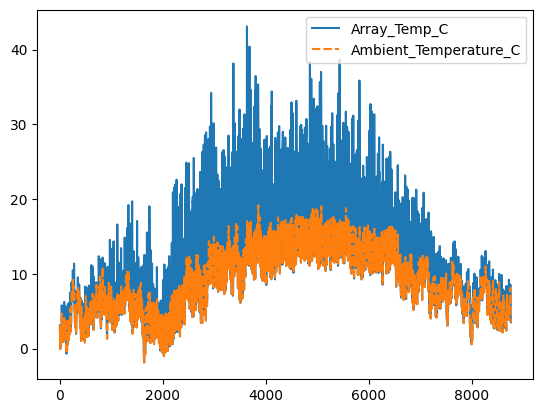

In [24]:
sns.lineplot(pv_model.models[0]["model_result"][["Array_Temp_C", "Ambient_Temperature_C"]])

In [25]:
px.line(pv_model.models[0]["model_result"][["ET_HRad_kWm2", "E_POA_kWm2"]])

<Axes: >

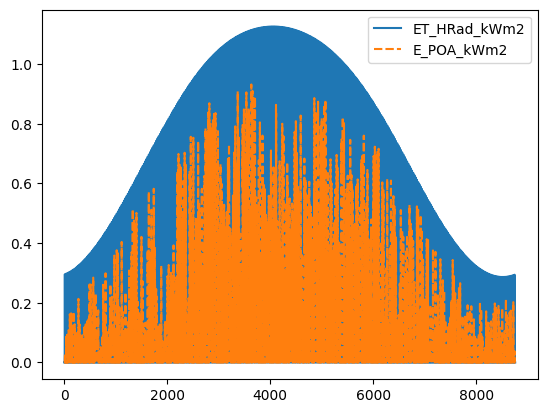

In [26]:
sns.lineplot(pv_model.models[0]["model_result"][["ET_HRad_kWm2", "E_POA_kWm2"]])

# ***VISUAL TESTING***

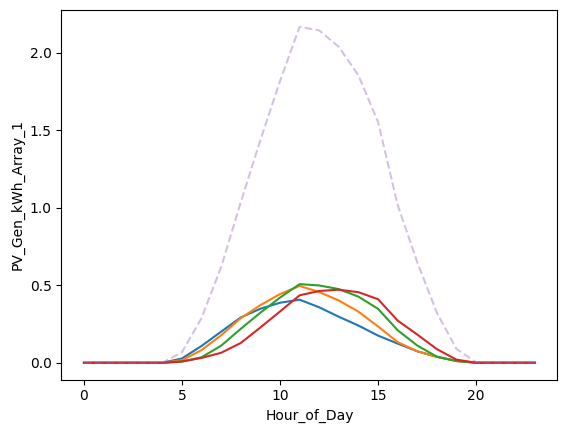

In [27]:
variables = ['E_Beam_kWm2', 'E_Diffuse_kWm2', 'E_Ground_kWm2', 'E_POA_kWm2', 'ET_HRad_kWm2', 
            'Array_Temp_C', 'PV_Gen_kWh', 'AOI', 'Zenith_Angle']

testy = pv_model.all_models

variable = "PV_Gen_kWh"

variable_1 = f"{variable}_Array_1"
variable_2 = f"{variable}_Array_2"
variable_3 = f"{variable}_Array_3"
variable_4 = f"{variable}_Array_4"
variable_7 = f"{variable}_Total"
variable_8 = f"{variable}_Avg"

if variable_1 in testy:
    sns.lineplot(testy.groupby("Hour_of_Day")[variable_1].mean())
if variable_2 in testy:
    sns.lineplot(testy.groupby("Hour_of_Day")[variable_2].mean())
if variable_3 in testy:
    sns.lineplot(testy.groupby("Hour_of_Day")[variable_3].mean())
if variable_4 in testy:
    sns.lineplot(testy.groupby("Hour_of_Day")[variable_4].mean())
if variable_7 in testy:
    sns.lineplot(testy.groupby("Hour_of_Day")[variable_7].mean(), alpha=0.4, ls="--")
if variable_8 in testy:
    sns.lineplot(testy.groupby("Hour_of_Day")[variable_8].mean(), alpha=0.4, ls="--")

<Axes: ylabel='Array_Temp_C_Avg'>

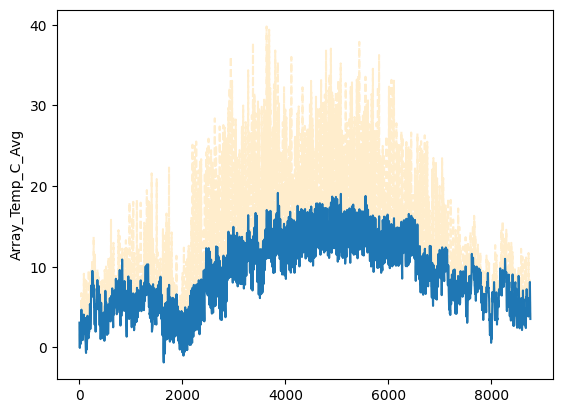

In [28]:
sns.lineplot(pv_model.combined_model["Array_Temp_C_Avg"], alpha = 0.2, ls = "--", color = "orange")
sns.lineplot(pv_model.combined_model["Ambient_Temperature_C"])

2024-02-23 16:48:17,418 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-02-23 16:48:17,422 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='Hour_of_Day', ylabel='Array_Temp_C_Avg'>

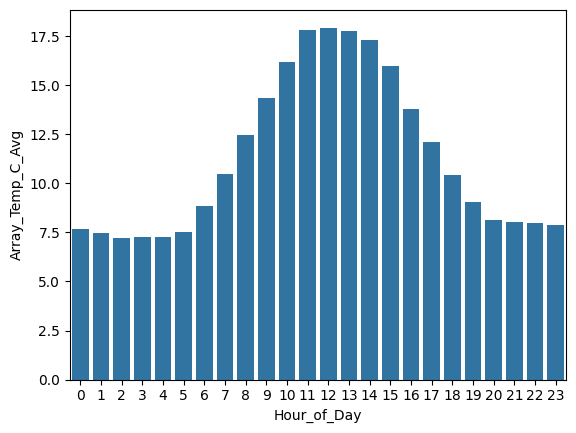

In [29]:
sns.barplot(pv_model.summary_grouped.hourly.Array_Temp_C_Avg)

<Axes: xlabel='Hour_of_Day', ylabel='PV_Gen_kWh_Total'>

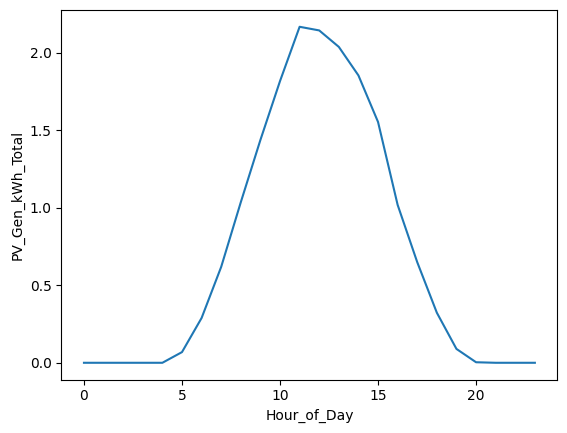

In [30]:
sns.lineplot(pv_model.combined_model.groupby("Hour_of_Day")["PV_Gen_kWh_Total"].mean())

In [31]:
pv_model.all_models["PV_Gen_kWh_Total"].sum()

6240.992716383999

In [32]:
pv_model.all_models.columns

Index(['E_Beam_kWm2_Array_1', 'E_Diffuse_kWm2_Array_1',
       'E_Ground_kWm2_Array_1', 'E_POA_kWm2_Array_1', 'Panel_POA_kWm2_Array_1',
       'ET_HRad_kWm2_Array_1', 'Array_Temp_C_Array_1', 'PV_Gen_kWh_Array_1',
       'PV_Thermal_Loss_kWh_Array_1', 'Low_Light_Loss_kWh_Array_1',
       'IAM_Loss_kWh_Array_1', 'AOI_Array_1', 'Zenith_Angle_Array_1',
       'E_Beam_kWm2_Array_2', 'E_Diffuse_kWm2_Array_2',
       'E_Ground_kWm2_Array_2', 'E_POA_kWm2_Array_2', 'Panel_POA_kWm2_Array_2',
       'ET_HRad_kWm2_Array_2', 'Array_Temp_C_Array_2', 'PV_Gen_kWh_Array_2',
       'PV_Thermal_Loss_kWh_Array_2', 'Low_Light_Loss_kWh_Array_2',
       'IAM_Loss_kWh_Array_2', 'AOI_Array_2', 'Zenith_Angle_Array_2',
       'E_Beam_kWm2_Array_3', 'E_Diffuse_kWm2_Array_3',
       'E_Ground_kWm2_Array_3', 'E_POA_kWm2_Array_3', 'Panel_POA_kWm2_Array_3',
       'ET_HRad_kWm2_Array_3', 'Array_Temp_C_Array_3', 'PV_Gen_kWh_Array_3',
       'PV_Thermal_Loss_kWh_Array_3', 'Low_Light_Loss_kWh_Array_3',
       'IAM_Loss_

<Axes: ylabel='PV_Thermal_Loss_kWh_Total'>

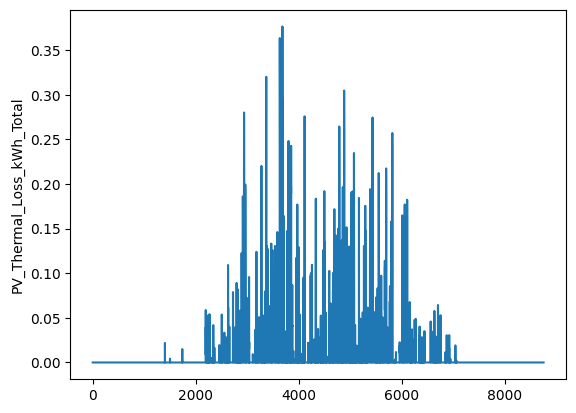

In [33]:
sns.lineplot(pv_model.all_models["PV_Thermal_Loss_kWh_Total"])

In [34]:
temp_losses = (pv_model.all_models["PV_Thermal_Loss_kWh_Total"].sum() / pv_model.all_models["PV_Gen_kWh_Total"].sum() * 100)

print(f"{round(temp_losses, 3)}% change to power due to temperature losses")

0.804% change to power due to temperature losses


In [35]:
pv_model.models[0]["model_result"]

,Hour_of_Day,Day_of_Year,Week_of_Year,Month_of_Year,Wind_Speed_ms,Ambient_Temperature_C,Declination_Angle,Solar_Time,Hour_Angle,AOI,...,E_Ground_kWm2,E_POA_kWm2,Panel_POA_kWm2,IAM_Loss_kWh,ET_HRad_kWm2,PV_Derated_Eff,Array_Temp_C,PV_Gen_kWh,PV_Thermal_Loss_kWh,Low_Light_Loss_kWh
0,0,1,1,1,5.700,3.070,-23.012,0.056,-179.155,133.623,...,0.000,0.000,0.000,0.000,0.000,1.000,3.070,0.000,0.000,0.000
1,1,1,1,1,5.730,2.630,-23.012,1.056,-164.155,122.480,...,0.000,0.000,0.000,0.000,0.000,1.000,2.630,0.000,0.000,0.000
2,2,1,1,1,5.770,2.180,-23.012,2.056,-149.155,111.426,...,0.000,0.000,0.000,0.000,0.000,1.000,2.180,0.000,0.000,0.000
3,3,1,1,1,5.800,1.730,-23.012,3.056,-134.155,100.747,...,0.000,0.000,0.000,0.000,0.000,1.000,1.730,0.000,0.000,0.000
4,4,1,1,1,5.840,1.280,-23.012,4.056,-119.155,90.730,...,0.000,0.000,0.000,0.000,0.000,1.000,1.280,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,19,365,52,12,5.520,5.310,-23.086,19.064,105.958,152.766,...,0.000,0.000,0.000,0.000,0.000,0.995,5.310,0.000,0.000,0.000
8756,20,365,52,12,5.550,4.860,-23.086,20.064,120.958,159.857,...,0.000,0.000,0.000,0.000,0.000,0.995,4.860,0.000,0.000,0.000
8757,21,365,52,12,5.590,4.410,-23.086,21.064,135.958,160.457,...,0.000,0.000,0.000,0.000,0.000,0.995,4.410,0.000,0.000,0.000
8758,22,365,52,12,5.630,3.970,-23.086,22.064,150.958,154.101,...,0.000,0.000,0.000,0.000,0.000,0.995,3.970,0.000,0.000,0.000


In [36]:
pv_model.all_models

,E_Beam_kWm2_Array_1,E_Diffuse_kWm2_Array_1,E_Ground_kWm2_Array_1,E_POA_kWm2_Array_1,Panel_POA_kWm2_Array_1,ET_HRad_kWm2_Array_1,Array_Temp_C_Array_1,PV_Gen_kWh_Array_1,PV_Thermal_Loss_kWh_Array_1,Low_Light_Loss_kWh_Array_1,...,IAM_Loss_kWh_Total,Declination_Angle,Solar_Time,Hour_Angle,Ambient_Temperature_C,Wind_Speed_ms,Hour_of_Day,Day_of_Year,Week_of_Year,Month_of_Year
0,0.000,0.000,0.000,0.000,0.000,0.000,3.070,0.000,0.000,0.000,...,0.000,-23.012,0.056,-179.155,3.070,5.700,0,1,1,1
1,0.000,0.000,0.000,0.000,0.000,0.000,2.630,0.000,0.000,0.000,...,0.000,-23.012,1.056,-164.155,2.630,5.730,1,1,1,1
2,0.000,0.000,0.000,0.000,0.000,0.000,2.180,0.000,0.000,0.000,...,0.000,-23.012,2.056,-149.155,2.180,5.770,2,1,1,1
3,0.000,0.000,0.000,0.000,0.000,0.000,1.730,0.000,0.000,0.000,...,0.000,-23.012,3.056,-134.155,1.730,5.800,3,1,1,1
4,0.000,0.000,0.000,0.000,0.000,0.000,1.280,0.000,0.000,0.000,...,0.000,-23.012,4.056,-119.155,1.280,5.840,4,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,0.000,0.000,0.000,0.000,0.000,0.000,5.310,0.000,0.000,0.000,...,0.000,-23.086,19.064,105.958,5.310,5.520,19,365,52,12
8756,0.000,0.000,0.000,0.000,0.000,0.000,4.860,0.000,0.000,0.000,...,0.000,-23.086,20.064,120.958,4.860,5.550,20,365,52,12
8757,0.000,0.000,0.000,0.000,0.000,0.000,4.410,0.000,0.000,0.000,...,0.000,-23.086,21.064,135.958,4.410,5.590,21,365,52,12
8758,0.000,0.000,0.000,0.000,0.000,0.000,3.970,0.000,0.000,0.000,...,0.000,-23.086,22.064,150.958,3.970,5.630,22,365,52,12


In [37]:
pv_model.summary

PV_Gen_kWh_Annual              6240.993
PV_Gen_kWh_Lifetime          146288.869
E_POA_kWm2_Annual               956.222
Panel_POA_kWm2_Annual           932.993
IAM_Loss_kWh_Annual             147.804
PV_Thermal_Loss_kWh_Annual       50.151
Low_Light_Loss_kWh_Annual       294.468
E_Beam_kWm2_Annual              421.631
E_Diffuse_kWm2_Annual           517.524
E_Ground_kWm2_Annual             17.067
ET_HRad_kWm2_Annual            2270.579
Array_Temp_C_Avg                 11.281
Ambient_Temperature_C_Avg         8.899
dtype: float64

In [38]:
pv_model.summary_grouped.daily

,PV_Gen_kWh_Total,E_POA_kWm2_Avg,Panel_POA_kWm2_Avg,IAM_Loss_kWh_Total,PV_Thermal_Loss_kWh_Total,Low_Light_Loss_kWh_Total,E_Beam_kWm2_Avg,E_Diffuse_kWm2_Avg,E_Ground_kWm2_Avg,ET_HRad_kWm2_Avg,Array_Temp_C_Avg,Ambient_Temperature_C
Day_of_Year,,,,,,,,,,,,
1,0.611,0.108,0.108,0.000,0.000,0.154,0.000,0.106,0.002,1.382,1.513,1.417
2,2.186,0.379,0.366,0.087,0.000,0.400,0.143,0.230,0.006,1.395,2.819,2.522
3,2.104,0.362,0.349,0.089,0.000,0.364,0.148,0.209,0.006,1.412,1.997,1.600
4,3.694,0.624,0.590,0.215,0.000,0.481,0.338,0.278,0.008,1.429,3.253,2.676
5,4.485,0.756,0.705,0.306,0.000,0.501,0.463,0.283,0.010,1.448,2.782,2.215
...,...,...,...,...,...,...,...,...,...,...,...,...
361,5.336,0.898,0.833,0.392,0.000,0.526,0.595,0.293,0.011,1.338,4.446,3.663
362,4.333,0.723,0.678,0.275,0.000,0.441,0.411,0.302,0.010,1.344,5.332,4.654
363,1.995,0.349,0.336,0.085,0.000,0.368,0.123,0.220,0.006,1.352,5.818,5.499


In [39]:
pv_model.summary

PV_Gen_kWh_Annual              6240.993
PV_Gen_kWh_Lifetime          146288.869
E_POA_kWm2_Annual               956.222
Panel_POA_kWm2_Annual           932.993
IAM_Loss_kWh_Annual             147.804
PV_Thermal_Loss_kWh_Annual       50.151
Low_Light_Loss_kWh_Annual       294.468
E_Beam_kWm2_Annual              421.631
E_Diffuse_kWm2_Annual           517.524
E_Ground_kWm2_Annual             17.067
ET_HRad_kWm2_Annual            2270.579
Array_Temp_C_Avg                 11.281
Ambient_Temperature_C_Avg         8.899
dtype: float64

In [40]:
pv_model.summary_grouped.monthly

,PV_Gen_kWh_Total,E_POA_kWm2_Avg,Panel_POA_kWm2_Avg,IAM_Loss_kWh_Total,PV_Thermal_Loss_kWh_Total,Low_Light_Loss_kWh_Total,E_Beam_kWm2_Avg,E_Diffuse_kWm2_Avg,E_Ground_kWm2_Avg,ET_HRad_kWm2_Avg,Array_Temp_C_Avg,Ambient_Temperature_C
Month_of_Year,,,,,,,,,,,,
1,136.693,22.584,21.336,7.675,0.000,14.225,12.564,9.710,0.310,55.033,4.508,3.964
2,246.352,39.015,37.463,9.847,0.022,18.515,19.918,18.498,0.600,89.614,7.017,5.736
3,286.270,45.049,44.310,4.860,0.022,26.896,12.095,32.152,0.802,171.684,4.592,3.241
4,760.887,114.434,111.888,16.494,1.715,27.908,53.290,59.089,2.055,247.681,10.312,6.774
5,1013.097,152.237,149.072,20.235,9.569,30.141,72.355,77.046,2.836,324.054,15.411,11.035
6,890.917,135.273,132.759,15.910,12.081,34.241,55.340,77.351,2.583,343.343,17.374,13.222
7,872.148,132.361,130.065,14.539,10.802,34.867,47.446,82.399,2.516,339.285,18.268,14.425
8,850.643,129.467,126.664,17.820,11.135,31.678,57.414,69.696,2.357,280.979,17.857,13.902
9,553.646,85.018,82.928,13.394,3.985,27.104,38.404,45.139,1.475,193.464,15.228,12.699


# ***EXPERIMENTAL***

# Low Light Losses Visualisation Test

In [41]:
import numpy as np
import plotly.express as px

# Define the modified logistic function
def calc_low_light_losses(pv_kwp, e_poa, k=0.0075, midpoint=25):
    """
    Modified logistic function to calculate efficiency based on irradiance,
    with a minimum efficiency level.

    Parameters:
    pv_kwp (float): The rated solar PV size (kWp).
    e_poa (float): The irradiance incident on array (W/m2).
    k (float): The steepness of the curve.
    midpoint (float): The irradiance at which the efficiency is at its midpoint.

    Returns:
    float: The calculated efficiency at the given irradiance.
    """
    pv_kwp_min = pv_kwp * 0.6
    eff = pv_kwp_min + (pv_kwp - pv_kwp_min) / (1 + np.exp(-k * (e_poa - midpoint)))
    return eff


# Generate a range of irradiance values from 0 to 1000 W/m2 and set L to 1 kWp
L = 1
irradiance_range = np.linspace(0, 1000, 1001)
efficiencies = calc_low_light_losses(L, irradiance_range)

# Plot Graph of results
fig = px.line(efficiencies[:], y=efficiencies[:], x = irradiance_range[:])

fig.update_layout(xaxis_title="Irradiation (W/m2)", yaxis_title="kWp Output",
                  title = "Line graph showing PV kWp output due to low irradiance losses")

In [42]:
calc_low_light_losses(1, 200)

0.9151724782571579

In [43]:
px.bar(pv_model.summary_grouped.monthly[["PV_Gen_kWh_Total", "IAM_Loss_kWh_Total", 
                                         "PV_Thermal_Loss_kWh_Total", "Low_Light_Loss_kWh_Total"]])

In [44]:
pv_model.summary_grouped.hourly.columns

Index(['PV_Gen_kWh_Total', 'E_POA_kWm2_Avg', 'Panel_POA_kWm2_Avg',
       'IAM_Loss_kWh_Total', 'PV_Thermal_Loss_kWh_Total',
       'Low_Light_Loss_kWh_Total', 'E_Beam_kWm2_Avg', 'E_Diffuse_kWm2_Avg',
       'E_Ground_kWm2_Avg', 'ET_HRad_kWm2_Avg', 'Array_Temp_C_Avg',
       'Ambient_Temperature_C'],
      dtype='object')

# Temperature Tests

In [45]:
import math

def calc_array_temp_homer(
    e_poa,
    ambient_temp,
    cell_temp_coeff=-0.0035,
    electrical_eff=0.21,
    cell_NOCT=42,
    ambient_NOCT=20,
    e_poa_NOCT=800,
    cell_temp_STC=25,
    transmittance_absorptance=0.9,
):
    """Calculates the cell temperature of a PV panel.

    Parameters:
    - e_poa: Plane of array irradiance in kW/m^2.
    - ambient_temp: Ambient temperature in degrees Celsius.
    - cell_temp_coeff: Temperature coefficient of the PV cell.
    - electrical_eff: Electrical efficiency of the PV panel.
    - cell_NOCT, ambient_NOCT: Nominal operating cell temperature and the corresponding ambient temperature.
    - e_poa_NOCT: Irradiance at NOCT conditions in W/m^2.
    - cell_temp_STC: Cell temperature at standard test conditions in degrees Celsius.
    - transmittance_absorptance: Transmittance and absorptance product of the PV panel.

    Returns:
    - Cell temperature of the PV panel.
    """
    temp_factor = (cell_NOCT - ambient_NOCT) * ((e_poa * 1000) / e_poa_NOCT)
    numerator = ambient_temp + temp_factor * (
        1
        - (electrical_eff * (1 - cell_temp_coeff * cell_temp_STC))
        / transmittance_absorptance
    )
    denominator = 1 + temp_factor * (
        cell_temp_coeff * electrical_eff / transmittance_absorptance
    )

    return numerator / denominator


def calc_array_temp_pvsyst(e_poa, ambient_temp, windspeed, uc=29, uv=1.2):
    u = uc + (uv * windspeed)
    tcell = ambient_temp + (1/u) * (0.9 * e_poa * 1000 * (1-0.21))
    return tcell

def calc_array_temp_sandia(e_poa: float, ambient_temp: float, wind_speed: float, 
                           a: float = -3.47, b: float = -0.0594) -> float:
    """
    Calculate the temperature of a photovoltaic (PV) array based on the Sandia method.
    
    Parameters:
    - e_poa (float): Plane of array irradiance in kW/m^2. Represents the solar irradiance incident on the PV array.
    - ambient_temp (float): Ambient temperature in degrees Celsius.
    - wind_speed (float): Wind speed in m/s at the site of the PV array.
    - a (float): Coefficient a in the exponential model, defaulting to -3.47.
    - b (float): Coefficient b in the exponential model, defaulting to -0.0594.
    
    Returns:
    - float: Estimated temperature of the PV array in degrees Celsius.
    """
    array_temp = e_poa * 1000 * math.exp(a + b * wind_speed) + ambient_temp
    return array_temp

def calc_array_temp_faiman(e_poa, ambient_temp, wind_speed, U_0=25, U_1=6.84):
    array_temp = ambient_temp + (e_poa * 1000 / (U_0 + U_1 * wind_speed))
    return array_temp


# Example usage:
e_poa=0.5
ambient_temp=25
wind_speed=1

list_1 = []
list_2 = []
list_3 = []
list_4 = []
list_5 = []


print("")
wind_speed=10
for i in range(1):
    cell_temperature = calc_array_temp_homer(e_poa, ambient_temp)
    print(f"The cell temperature is {cell_temperature:.2f}°C from the Homer model with {wind_speed}m/s windspeed")
    list_2.append(cell_temperature)
    wind_speed += 1

print("")
wind_speed=0
for i in range(26):
    cell_temperature = calc_array_temp_pvsyst(e_poa, ambient_temp, wind_speed)
    print(f"The cell temperature is {cell_temperature:.2f}°C from the PVSyst model with {wind_speed}m/s windspeed")
    list_3.append(cell_temperature)
    wind_speed += 1

print("")
wind_speed=0
for i in range(26):
    cell_temperature = calc_array_temp_sandia(e_poa, ambient_temp, wind_speed)
    print(f"The cell temperature is {cell_temperature:.2f}°C from the Sandia model with {wind_speed}m/s windspeed")
    list_4.append(cell_temperature)
    wind_speed += 1

print("")
wind_speed=0
for i in range(26):
    cell_temperature = calc_array_temp_faiman(e_poa, ambient_temp, wind_speed)
    print(f"The cell temperature is {cell_temperature:.2f}°C from the Faiman model with {wind_speed}m/s windspeed")
    list_5.append(cell_temperature)
    wind_speed += 1


The cell temperature is 35.66°C from the Homer model with 10m/s windspeed

The cell temperature is 37.26°C from the PVSyst model with 0m/s windspeed
The cell temperature is 36.77°C from the PVSyst model with 1m/s windspeed
The cell temperature is 36.32°C from the PVSyst model with 2m/s windspeed
The cell temperature is 35.90°C from the PVSyst model with 3m/s windspeed
The cell temperature is 35.52°C from the PVSyst model with 4m/s windspeed
The cell temperature is 35.16°C from the PVSyst model with 5m/s windspeed
The cell temperature is 34.82°C from the PVSyst model with 6m/s windspeed
The cell temperature is 34.51°C from the PVSyst model with 7m/s windspeed
The cell temperature is 34.21°C from the PVSyst model with 8m/s windspeed
The cell temperature is 33.93°C from the PVSyst model with 9m/s windspeed
The cell temperature is 33.67°C from the PVSyst model with 10m/s windspeed
The cell temperature is 33.42°C from the PVSyst model with 11m/s windspeed
The cell temperature is 33.19°C fr

In [46]:
%%timeit
cell_temperature = calc_array_temp_homer(e_poa, ambient_temp)

421 ns ± 1.22 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [47]:
%%timeit
cell_temperature = calc_array_temp_faiman(e_poa, ambient_temp, wind_speed)

192 ns ± 2.21 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [48]:
%%timeit
cell_temperature = calc_array_temp_sandia(e_poa, ambient_temp, wind_speed)

227 ns ± 3.47 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [49]:
%%timeit
cell_temperature = calc_array_temp_pvsyst(e_poa, ambient_temp, wind_speed)

260 ns ± 11.5 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
